In [2]:
import os, sys
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

from pathlib import Path
from glob import glob
from solar_plotting import constant_below_threshold, mean_below_threshold, day_time_df, day_time_heatmap

from spectrum import pmtm
import pywt
from scipy.signal import welch

In [18]:
plt.rcParams.update({
    'axes.titlesize': 22,
    'axes.labelsize': 18,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 16
})

# Prepare Data

In [3]:
regions = ['Q', 'N', 'V', 'S', 'T']  # Add all your region codes here
base_path = Path('/g/data/er8/users/cd3022/solar_drought/REZ/capacity_factor/')

region_darrays = {}

for region in regions:
    file_path = base_path / region
    files = list(file_path.rglob("*.nc"))
    ds_region = xr.open_mfdataset(files, combine='by_coords')
    
    # Assume there's only one data variable in the dataset
    data_var = list(ds_region.data_vars)[0]
    region_darrays[region] = ds_region[data_var]

# Combine into one dataset, with each region as a variable
ds_aus = xr.Dataset(region_darrays)
ds_aus = ds_aus.load()

time_utc = pd.to_datetime(ds_aus.time.values)
time_aest = time_utc.tz_localize("UTC").tz_convert("Australia/Brisbane")
time_aest_naive = time_aest.tz_convert("Australia/Brisbane").tz_localize(None)
ds_aus = ds_aus.assign_coords(time=("time", time_aest_naive))

ERROR 1: PROJ: proj_create_from_database: Open of /g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/share/proj failed


In [4]:
# Rated capacity taken from sandia_modules['Canadian_Solar_CS5P_220M___2009_'], solar panel used in pvlib system,
# using the calculation rated_capacity = module.loc['Impo'] * module.loc['Vmpo']
rated_capacity = 219.656729124
ds_aus = ds_aus.apply(lambda x: x / rated_capacity)

# REMOVE MIDDLE OF THE DAY MISSING VALUE

In [55]:
ds_clean = ds_aus.where(ds_aus['time'].dt.strftime('%H:%M') != '12:40', drop=True)

# REMOVE BAD DUSK AND DAWN DATA

In [132]:
def clip_dusk_dawn(da, n=1):
    """Set the first and last `n` non-NaN values of each day in a 1D time series to NaN."""
    da_out = da.copy()
    grouped = da.groupby('time.date')

    for date, day_group in grouped:
        # Get the original indexes of the day's data
        indices = da.time.to_index().get_indexer(day_group.time)

        # Find non-NaN values
        numeric = day_group.values
        valid_idxs = np.where(~np.isnan(numeric))[0]

        # Indices to set to NaN: first n and last n non-NaNs
        to_nan = np.concatenate([valid_idxs[:n], valid_idxs[-n:]])
        times_to_nan = day_group.time[to_nan]
        da_out.loc[{'time': times_to_nan}] = np.nan

    return da_out

ds_clipped = ds_clean.copy()
for state in regions:
    ds_clipped[state] = clip_dusk_dawn(ds_clean[state], n=3)

# Constant below threshold

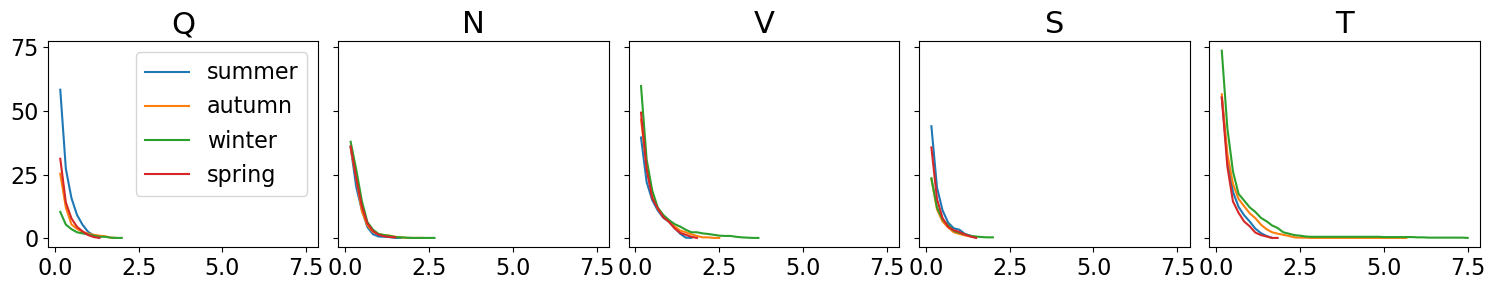

In [135]:
fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize=(15,3), sharex=True, sharey=True)

for i, state in enumerate(regions):
    cbt = constant_below_threshold(da=ds_clipped[state], threshold=0.1)
    for season in cbt:
        ax[i].plot(cbt[season][0], cbt[season][1], label=season)
    ax[i].set_title(state, rotation=0)
    ax[0].legend()

plt.tight_layout()
plt.show()

# Mean Below Threshold

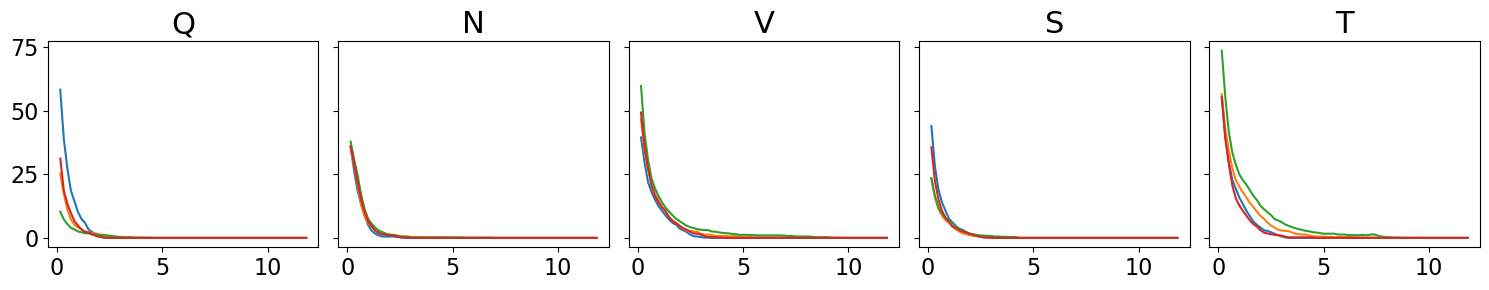

In [137]:
fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize=(15,3), sharex=True, sharey=True)

for i, state in enumerate(regions):
    mbt = mean_below_threshold(da=ds_clipped[state], threshold=0.1, max_hours=12)
    ax[i].plot(mbt)
    ax[i].set_title(state, rotation=0)

plt.tight_layout()
plt.show()

# Multti-Day Droughts

In [138]:
def daily_drought(da, threshold):
    res = []
    dates = []
    for date, day_data in da.groupby('time.date'):
        day_drought = xr.where(day_data < threshold, 1, 0).data
    
        # get the maximum "drought" length for this day
        drought_lengths = [0]
        for i in range(1, len(day_drought)):
            drought_past = day_drought[i - 1]
            drought_now = day_drought[i]
            if (drought_now != 0) and (drought_past != 0):
                drought_now += drought_lengths[i - 1]
            drought_lengths.append(drought_now)
        max_length = np.max(drought_lengths)
    
        
        # Different criteria for assessing if this day is a "drought"
        if np.sum(day_drought) > 12: # total 2 hrs below threshold
            res.append(1)
        elif max_length >= 6: # at least 1 hour below threshold
            
            res.append(1)
        elif day_data.mean().data < 0.5: # mean for the whole day below threshold
            
            res.append(1)
        else:
            res.append(0)
        dates.append(np.datetime64(date))
    
    temp_da = xr.DataArray(res, coords={'time': dates}, dims='time')
    
    seasons = {
        'summer': [12,1,2],
        'autumn': [3,4,5],
        'winter': [6,7,8],
        'spring': [9,10,11]
    }
        
    results = {}
    for season in seasons:
        data = temp_da.where(temp_da.time.dt.month.isin(seasons[season]), drop=True).values
    
        drought_lengths = [0]
        for i_time in range(1, len(data)):
            drought_past = data[i_time - 1]
            drought_now = data[i_time]
            if (drought_now != 0) and (drought_past != 0):
                drought_now += drought_lengths[i_time - 1]
            drought_lengths.append(drought_now)
    
        length, freq = np.unique(drought_lengths, return_counts = True)
        length = np.array(length[1:])
        # num / season in data
        freq = freq[1:] / len(np.unique(temp_da.time.dt.year))
        results[season] = (length, freq)
    return results

/jobfs/139811702.gadi-pbs/ipykernel_307065/3816323807.py:31: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  temp_da = xr.DataArray(res, coords={'time': dates}, dims='time')
/jobfs/139811702.gadi-pbs/ipykernel_307065/3816323807.py:31: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable

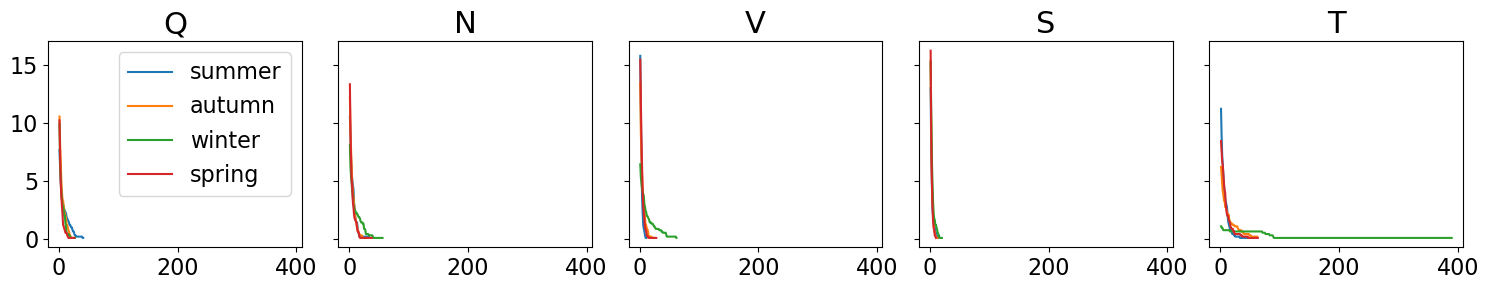

In [141]:
fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize=(15,3), sharex=True, sharey=True)

for i, state in enumerate(regions):
    cbt = daily_drought(da=ds_clipped[state], threshold = 0.5)
    for season in cbt:
        ax[i].plot(cbt[season][0], cbt[season][1], label=season)
    ax[i].set_title(state)
    ax[0].legend()

plt.tight_layout()
plt.show()

# Time of Day

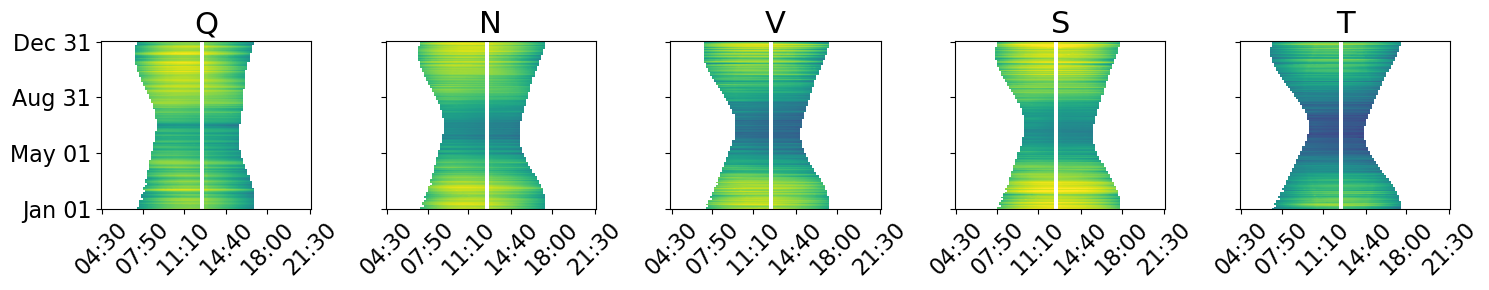

In [131]:
fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize=(15,3), sharex=True, sharey=True)
for i, state in enumerate(regions):
    df = day_time_df(ds_clipped[state])

    cmap = plt.cm.viridis
    cmap.set_bad(color='white')
    ax[i].imshow(df, aspect="auto", origin="lower", cmap=cmap, vmin=0, vmax=1)
    ax[i].set_title(state, rotation=0)

    # Set x-axis labels (time of day)
    xticks = np.linspace(0, len(df.columns) - 1, 6, dtype=int)  # Select 12 evenly spaced time labels
    xtick_labels = [df.columns[i].strftime("%H:%M") for i in xticks]  # Format as HH:MM
    ax[i].set_xticks(xticks, xtick_labels, rotation=45)
    
    # Y-axis (Convert Day of Year → Month-Day)
    yticks = np.linspace(0, len(df.index) - 1, 4, dtype=int)  # Select 10 evenly spaced day labels
    ytick_labels = [(pd.Timestamp(f"2024-01-01") + pd.Timedelta(days=int(df.index[i]) - 1)).strftime("%b %d") for i in yticks]
    ax[i].set_yticks(yticks, ytick_labels)
    

plt.tight_layout()
plt.show()

# Spectral Analysis

In [23]:
def spectral_fft(da, time_res='1D', clim=False):
    daily_mean = da.resample(time=time_res).mean()
    if clim:
        clim = daily_mean.groupby("time.dayofyear").mean("time")
        daily_mean = daily_mean.groupby("time.dayofyear") - clim
    clean = daily_mean.dropna(dim="time")
    data = (clean - clean.mean(dim='time')).values

    N = len(data)
    fft_vals = np.fft.fft(data)
    freqs = np.fft.fftfreq(N, d=1)
    
    positive = freqs > 0
    freqs_pos = freqs[positive]
    power = np.abs(fft_vals[positive])**2 / N**2

    # Normalize to match variance via Parseval
    delta_f = freqs_pos[1] - freqs_pos[0]
    power *= np.var(data) / (np.sum(power) * delta_f)

    periods = 1 / freqs_pos
    return periods, power

def spectral_multitaper(da, NW=3, k=5):
    daily = da.resample(time="1D").mean()
    clean = daily.dropna(dim="time")
    signal = (clean - clean.mean(dim="time")).values

    Sk, weights, _ = pmtm(signal, NW=NW, k=k, method='adapt', show=False)
    weights = weights.T  # Ensure correct shape
    power = (np.abs(Sk)**2 * weights).mean(axis=0)

    freqs = np.linspace(0, 1, len(power), endpoint=False)  # cycles/day
    delta_f = freqs[1] - freqs[0]

    # Normalize using Parseval
    power *= np.var(signal) / (np.sum(power) * delta_f)

    periods = 1 / freqs[1:]
    power = power[1:]
    return periods, power

def spectral_welch(da, nperseg=2048, time_res='1D', clim=False):
    daily_mean = da.resample(time=time_res).mean()
    if clim:
        clim = daily_mean.groupby("time.dayofyear").mean("time")
        daily_mean = daily_mean.groupby("time.dayofyear") - clim
    clean = daily_mean.dropna(dim="time")
    signal = (clean - clean.mean(dim="time")).values

    fs = 1  # cycles/day
    freqs, pxx = welch(signal, fs=fs, nperseg=min(nperseg, len(signal)))

    # Normalize using Parseval
    delta_f = freqs[1] - freqs[0]
    pxx *= np.var(signal) / (np.sum(pxx) * delta_f)

    valid = freqs > 0
    periods = 1 / freqs[valid]
    power = pxx[valid]
    return periods, power 


INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _va

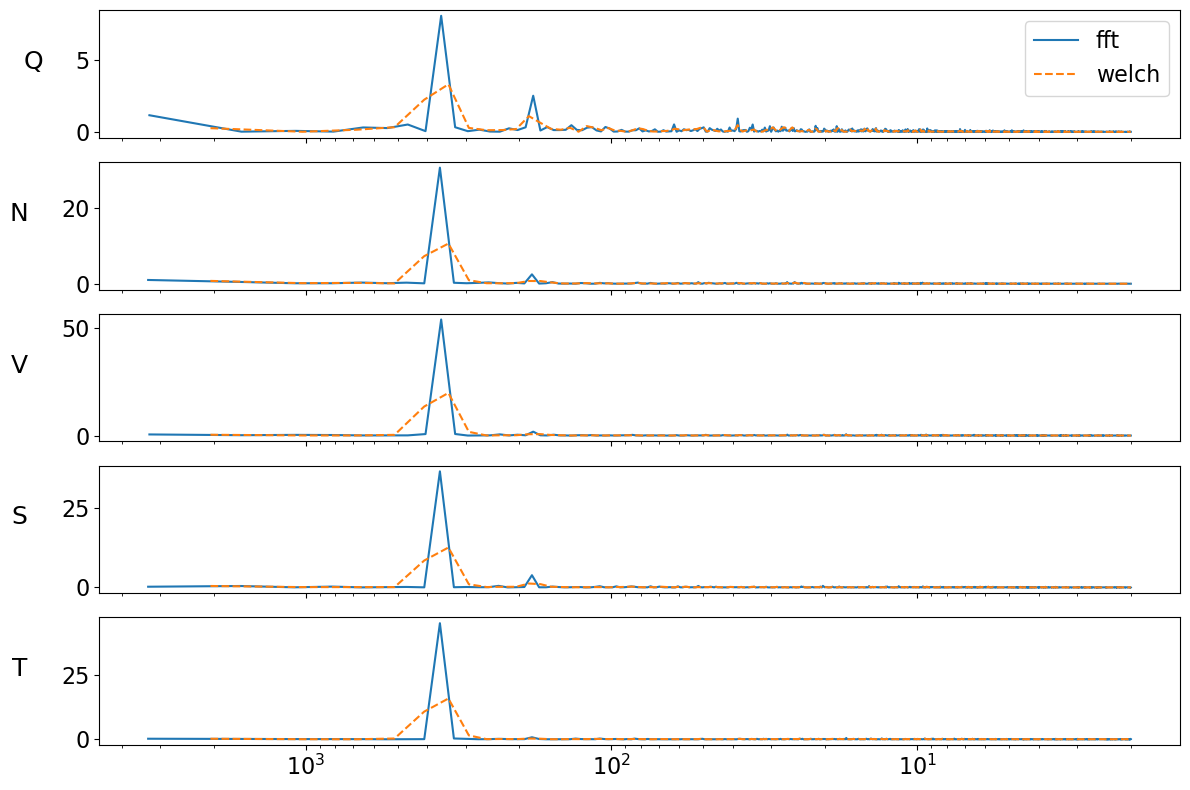

In [27]:
variables = ['Q', 'N', 'V', 'S', 'T']
# line_styles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1))]
colours = ['red', 'orange', 'blue', 'green', 'purple']
time_res = '1D'
clim=False

fig, ax = plt.subplots(nrows = 5, ncols = 1, figsize=(12,8), sharex=True)

for i, var in enumerate(variables):

    fft_periods, fft_power = spectral_fft(da=ds_aus[var], time_res=time_res, clim=clim)
    welch_periods, welch_power = spectral_welch(da=ds_aus[var], nperseg=2048, time_res=time_res, clim=clim)
    
    ax[i].semilogx(fft_periods, fft_power, label='fft')
    ax[i].semilogx(welch_periods, welch_power, label='welch', linestyle = '--')
    ax[i].set_ylabel(var, rotation=0, labelpad=30)
    ax[0].legend()
    
    fig.gca().invert_xaxis()
plt.tight_layout()

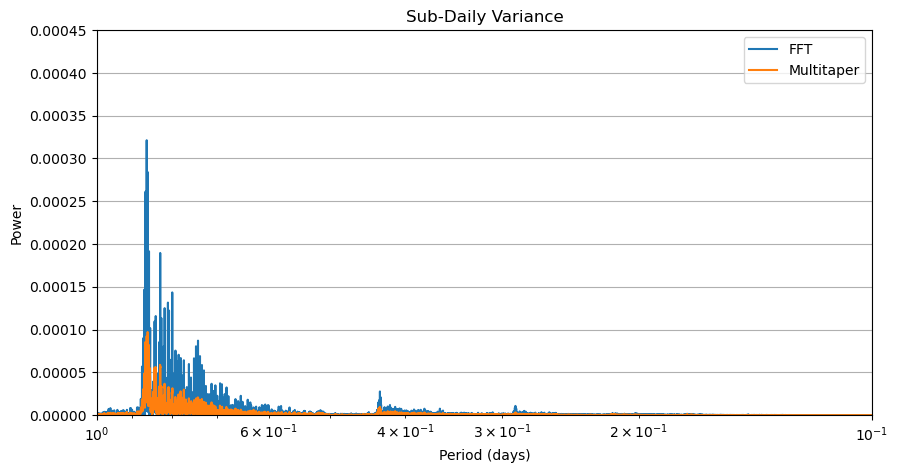

In [11]:
plt.figure(figsize=(10, 5))
plt.title('Sub-Daily Variance')
plt.plot(fft_periods, fft_power, label='FFT', color='tab:blue')
plt.plot(mt_periods[mt_mask], mt_power[mt_mask], label='Multitaper', color='tab:orange')
plt.legend()
plt.grid(True)
plt.xscale('log')
plt.gca().invert_xaxis()
plt.xlabel('Period (days)')
plt.ylabel('Power')
plt.xlim(1,0.1)
plt.ylim(0,0.00045)
plt.show()

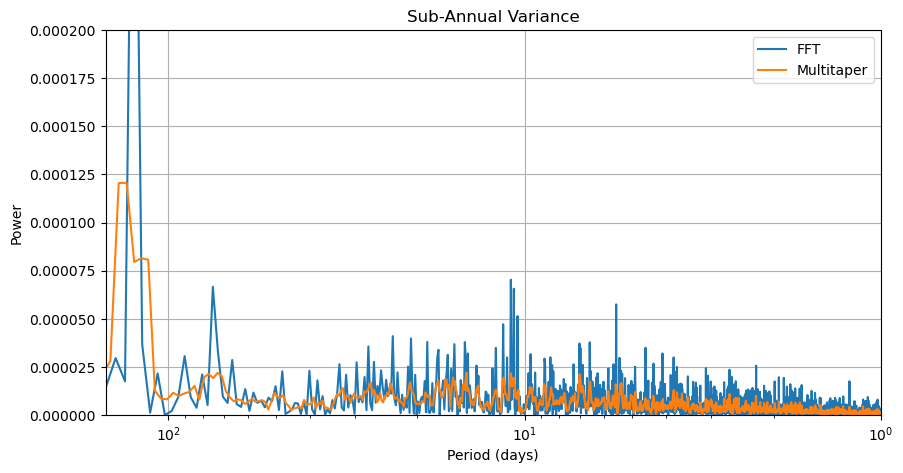

In [12]:
plt.figure(figsize=(10, 5))
plt.title('Sub-Annual Variance')
plt.plot(fft_periods, fft_power, label='FFT', color='tab:blue')
plt.plot(mt_periods[mt_mask], mt_power[mt_mask], label='Multitaper', color='tab:orange')
plt.legend()
plt.grid(True)
plt.xscale('log')
plt.gca().invert_xaxis()
plt.xlabel('Period (days)')
plt.ylabel('Power')
plt.xlim(150,1)
plt.ylim(0,0.0002)
plt.show()

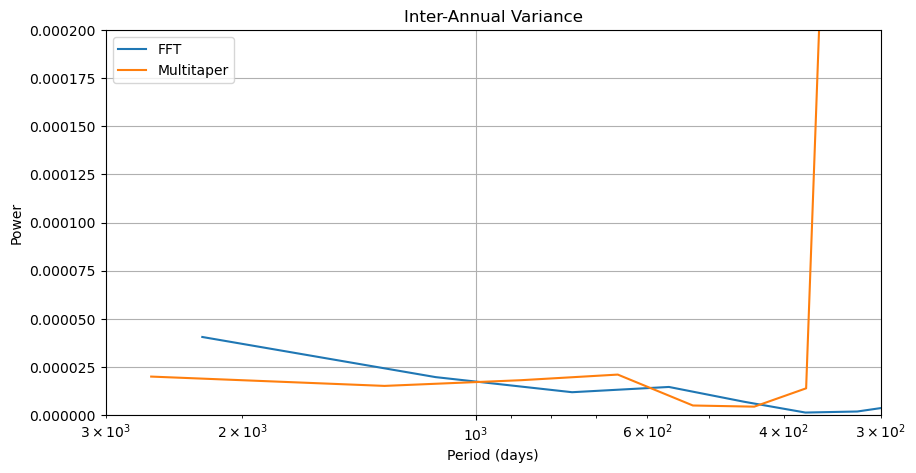

In [13]:
plt.figure(figsize=(10, 5))
plt.title('Inter-Annual Variance')
plt.plot(fft_periods, fft_power, label='FFT', color='tab:blue')
plt.plot(mt_periods[mt_mask], mt_power[mt_mask], label='Multitaper', color='tab:orange')
plt.legend()
plt.grid(True)
plt.xscale('log')
plt.gca().invert_xaxis()
plt.xlabel('Period (days)')
plt.ylabel('Power')
plt.xlim(3000,300)
plt.ylim(0,0.0002)
plt.show()

INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'


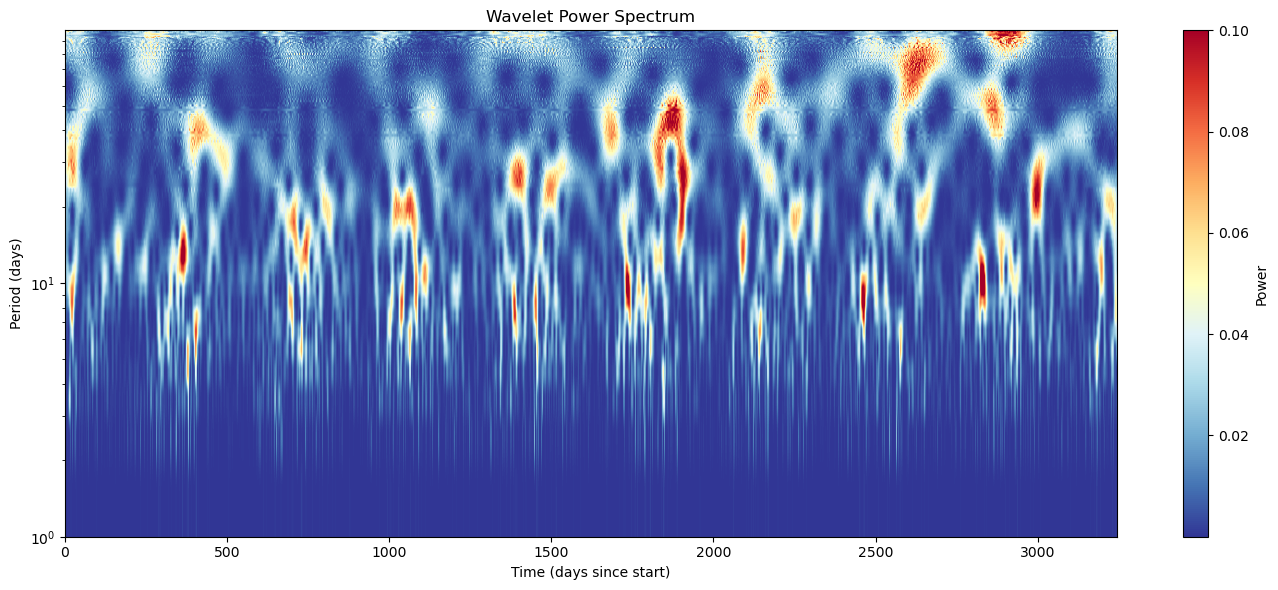

In [14]:
# Wavelet
daily = ds_aus.V.resample(time="1D").mean()
clean = daily.dropna(dim="time")
data = clean - clean.mean(dim="time")
signal = data.values

scales = np.arange(1, 100)
coefficients, freqs = pywt.cwt(signal, scales=scales, wavelet='cmor1-1', sampling_period=1)

# Compute power and apply log scale (add small constant to avoid log(0))
power = np.abs(coefficients) ** 2
log_power = np.log2(power + 1e-8)

plt.figure(figsize=(14, 6))
im = plt.imshow(power,
                extent=[0, len(signal), scales[-1], scales[0]], vmax = 0.1,
                aspect='auto', cmap='RdYlBu_r')

plt.gca().invert_yaxis()
cbar = plt.colorbar(im)
cbar.set_label("Power")

plt.xlabel("Time (days since start)")
plt.ylabel("Period (days)")
plt.title("Wavelet Power Spectrum")
plt.yscale('log')

plt.tight_layout()
plt.show()